In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1
)
from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

### Load channel data from both the basic and masking method

In [2]:
truth1 = IeeeGroundTruth(2, 1, directory = 'channel_data')  # masking method
truth1.align_rgb_bvp()
truth1.fill_nans()
truth1.process_rgb()
truth1.process_bvp()

truth2 = IeeeGroundTruth(2, 1, directory = 'channel_data3')  # basic method
truth2.align_rgb_bvp()
truth2.fill_nans()
truth2.process_rgb()
truth2.process_bvp()

### Compare data collected using the two different methods

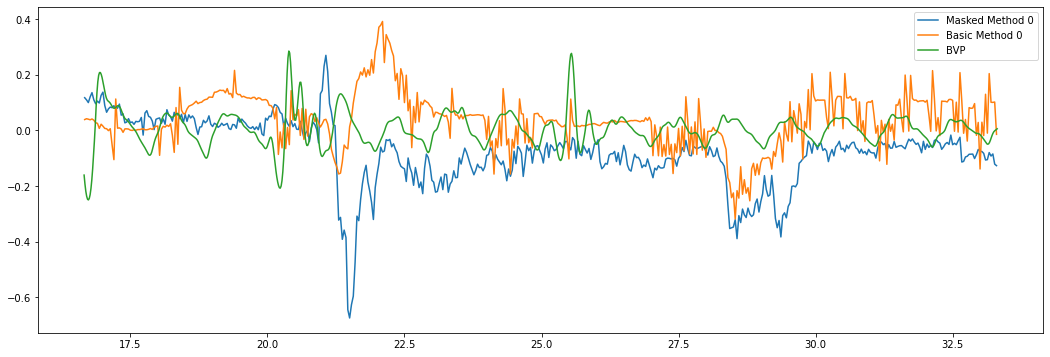

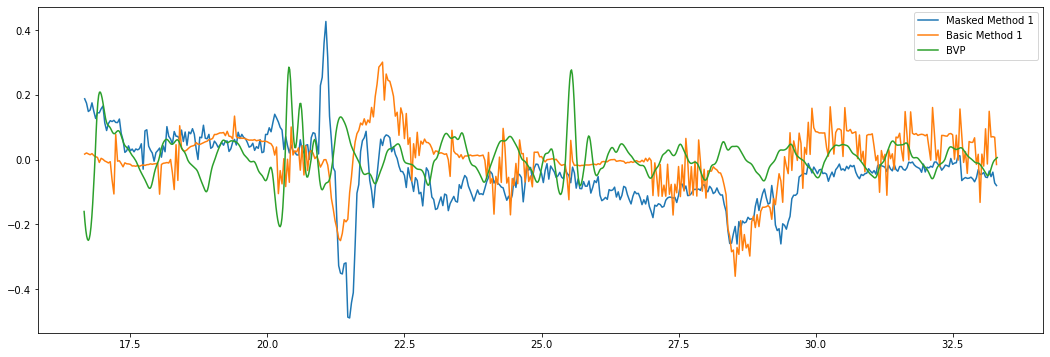

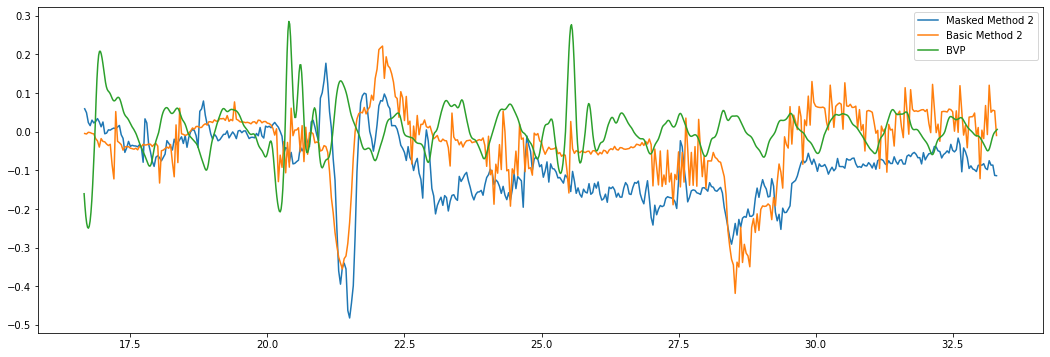

In [6]:
beg = 500
end = 1000

for i in range(truth1.rgb.shape[1]):
    rgb_index = np.arange(beg, end) / truth1.rgb_freq
    bvp_index = np.arange(truth1.align_indices(beg), truth1.align_indices(end)) / truth1.bvp_freq
    
    plt.plot(rgb_index, truth1.rgb[beg: end, i], label = f'Masked Method {i}')
    plt.plot(rgb_index, truth2.rgb[beg: end, i], label = f'Basic Method {i}')

    bvp_sample = truth1.bvp[truth1.align_indices(beg): truth1.align_indices(end)]
    plt.plot(bvp_index, bvp_sample, label = 'BVP')
    plt.legend()
    plt.show()

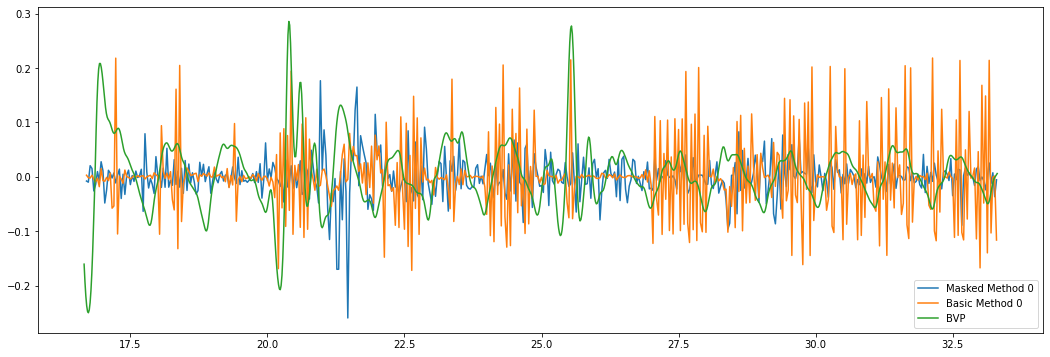

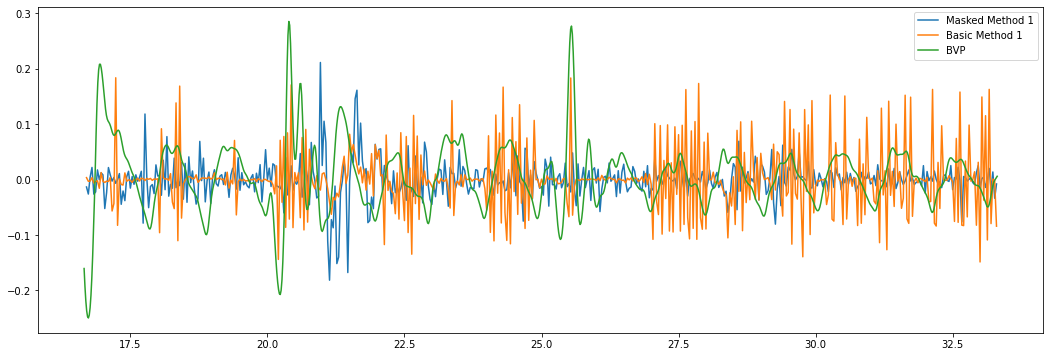

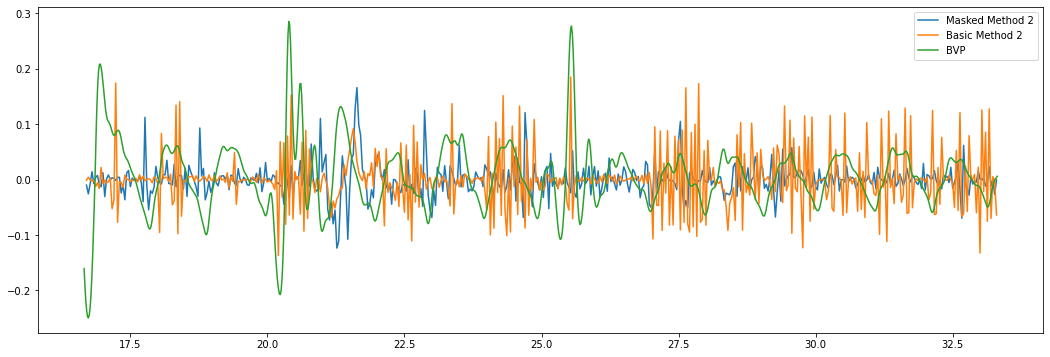

In [8]:
beg = 500
end = 1000

for i in range(truth1.rgb.shape[1]):
    rgb_index = np.arange(beg, end) / truth1.rgb_freq
    bvp_index = np.arange(truth1.align_indices(beg), truth1.align_indices(end)) / truth1.bvp_freq
    
    plt.plot(rgb_index[1: ], np.diff(truth1.rgb[beg: end, i]), label = f'Masked Method {i}')
    plt.plot(rgb_index[1: ], np.diff(truth2.rgb[beg: end, i]), label = f'Basic Method {i}')

    bvp_sample = truth1.bvp[truth1.align_indices(beg): truth1.align_indices(end)]
    plt.plot(bvp_index, bvp_sample, label = 'BVP')
    plt.legend()
    plt.show()

### Calculate mutual information between each feature and the bvp

In [37]:
def bin_and_convert(my_array, num_bins):
    # Compute the bin edges using numpy.linspace
    bin_edges = np.linspace(0, 1, num_bins+1)

    # Use numpy.digitize to get the bin indices for each element of the array
    bin_indices = np.digitize(my_array, bin_edges)-1

    # Return the bin indices as a new numpy array
    return bin_indices

In [38]:
import numpy as np
from scipy.interpolate import interp1d
from sklearn.metrics import normalized_mutual_info_score

def calc_mutual_info_resample(x, y, fs_x, fs_y):

    # Determine the lower and higher sampling rates
    if fs_x < fs_y:
        x_resampled = x
        y_resampled = interp1d(np.arange(len(y)) * fs_y / fs_x, y)(np.arange(len(x)))
    else:
        x_resampled = interp1d(np.arange(len(x)) * fs_x / fs_y, x)(np.arange(len(y)))
        y_resampled = y
    
    x_resampled = np.diff(x_resampled)
    y_resampled = y_resampled[1: ]
    
    x_resampled = normalize_signal(x_resampled)
    x_resampled = normalize_amplitude_to_1(x_resampled)

    x_resampled = bin_and_convert(x_resampled, 20)
    y_resampled = bin_and_convert(y_resampled, 20)

    # Calculate the mutual information between the resampled arrays
    mi = normalized_mutual_info_score(x_resampled, y_resampled)
    return mi


In [39]:
a = calc_mutual_info_resample(truth1.rgb[:, 0], truth1.bvp, truth1.rgb_freq, truth1.bvp_freq)
b = calc_mutual_info_resample(truth1.rgb[:, 1], truth1.bvp, truth1.rgb_freq, truth1.bvp_freq)
c = calc_mutual_info_resample(truth1.rgb[:, 2], truth1.bvp, truth1.rgb_freq, truth1.bvp_freq)
print(a, b, c, d)

0.00587350333148953 0.005164634360994435 0.003979442366649538 0.007013491617075231


In [40]:
a = calc_mutual_info_resample(truth2.rgb[:, 0], truth2.bvp, truth2.rgb_freq, truth2.bvp_freq)
b = calc_mutual_info_resample(truth2.rgb[:, 1], truth2.bvp, truth2.rgb_freq, truth2.bvp_freq)
c = calc_mutual_info_resample(truth2.rgb[:, 2], truth2.bvp, truth2.rgb_freq, truth2.bvp_freq)
print(a, b, c, d)

0.011526046139718905 0.011032463046374456 0.01007823927274833 0.007013491617075231
